# Dependency = Pregroup $\cap$ CFG

Recall the definitions of currying and uncurrying for rigid diagrams

In [1]:
from discopy.rigid import Id, Ty, Box, Diagram

def curry(diagram, n_wires=1, left=False):
    if not n_wires > 0:
        return diagram
    if left:
        wires = diagram.dom[:n_wires]
        return Diagram.caps(wires.r, wires) @ Id(diagram.dom[n_wires:])\
            >> Id(wires.r) @ diagram
    wires = diagram.dom[-n_wires:]
    return Id(diagram.dom[:-n_wires]) @ Diagram.caps(wires, wires.l)\
        >> diagram @ Id(wires.l)

def uncurry(diagram, n_wires=1, left=False):
    if not n_wires > 0:
        return diagram
    if left:
        wires = diagram.cod[:n_wires]
        return Id(wires.l) @ diagram\
            >> Diagram.cups(wires.l, wires) @ Id(diagram.cod[n_wires:])
    wires = diagram.cod[-n_wires:]
    return diagram @ Id(wires.r)\
        >> Id(diagram.cod[:-n_wires]) @ Diagram.cups(wires, wires.r)

## Interface SpaCy with rigid.Diagram

In [2]:
import spacy
nlp = spacy.load("en_core_web_sm")
doc = nlp("Hundreds of polar bears are storming through Sicily, running like crazy monkeys on skates")

In [3]:
def doc2rigid(word):
    children = word.children
    if not children:
        return Box(word.text, Ty(word.dep_), Ty())
    left = Ty(*[child.dep_ for child in word.lefts])
    right = Ty(*[child.dep_ for child in word.rights])
    box = Box(word.text, left.l @ Ty(word.dep_) @ right.r, Ty(), data=[left, Ty(word.dep_), right])
    top = curry(curry(box, n_wires=len(left), left=True), n_wires=len(right))
    bot = Id(Ty()).tensor(*[doc2rigid(child) for child in children])
    return top >> bot

def dep2pregroup(doc):
    root = find_root(doc)
    return doc2rigid(root)

def find_root(doc):
    for word in doc:
        if word.dep_ == 'ROOT':
            return word

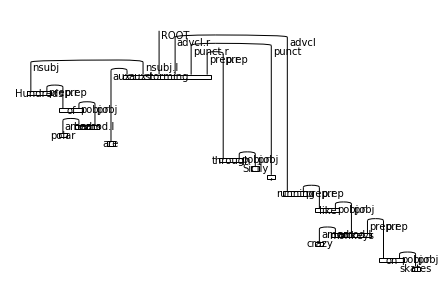

In [4]:
dep2pregroup(doc).draw()

## Interface SpaCy with operad.Tree

In [5]:
from discopy import operad

def find_root(doc):
    for word in doc:
        if word.dep_ == 'ROOT':
            return word

def doc2tree(word):
    if not word.children:
        return operad.Box(word.text, operad.Ob(word.dep_), [])
    root = operad.Box(word.text, operad.Ob(word.dep_),
                      [operad.Ob(child.dep_) for child in word.children])
    return root(*[doc2tree(child) for child in word.children])

def from_spacy(doc):
    root = find_root(doc)
    return doc2tree(root)

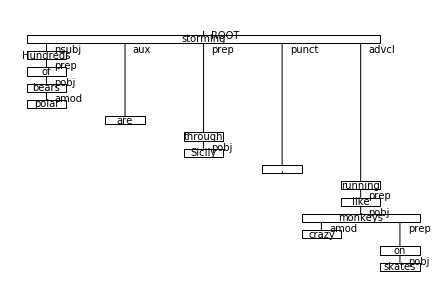

In [6]:
operad.tree2diagram(from_spacy(doc)).draw()

## Equivalence

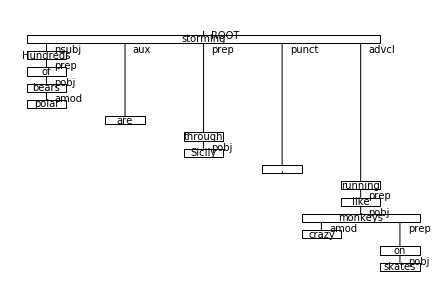

In [7]:
from discopy import rigid

def rewiring(box):
    if not box.data:
        return rigid.Box(box.name, box.dom, Ty())
    left, middle, right = box.data[0], box.data[1], box.data[2]
    new_box = rigid.Box(box.name, middle, left @ right) 
    return uncurry(uncurry(new_box, len(left), left=True), len(right))

F = rigid.Functor(ob=lambda ob: Ty(ob.name), ar=rewiring)
F(dep2pregroup(doc)).normal_form().draw()

In [8]:
assert repr(operad.tree2diagram(from_spacy(doc))) == repr(F(dep2pregroup(doc)).normal_form())